# Visualize simulated data

This notebook will verify that the simulated dataset is a good representation of our original input dataset by visually comparing the structures in the two datasets projected onto UMAP space.  This notebook is using the recount2 compendium.  

The overlapping structure of the original (pink) and simulated (grey) datasets demonstrates that our generative model is capturing the same biological trends in the original dataset.  

This figure can be found in the supplemental material of the manuscript.

In [17]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot, 
                      geom_point,
                      labs,
                      aes, 
                      facet_wrap, 
                      scale_color_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      element_line,
                      element_blank,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# User parameters
dataset_name = "Human_analysis"
analysis_name = 'Human_sample_lvl_sim'
NN_architecture = 'NN_2500_30'

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))    # base dir on repo
local_dir = "/home/alexandra/Documents"                          # base dir on local machine for data storage

NN_dir = base_dir + "/" + dataset_name + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data.tsv.xz")

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "experiment_simulated",
    analysis_name,
    "Experiment_1_0.txt.xz")

In [4]:
NN_dir

'/home/alexandra/Documents/Repos/Batch_effects_simulation/Human_analysis/models/NN_2500_30'

In [5]:
# Output files
umap_overlay_file = os.path.join(
    base_dir,
    "results",
    "Human_umap_overlay.png")

In [6]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(896, 58037)
(20, 58037)


In [7]:
normalized_data.head(10)

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR592745,0.818386,0.002542,0.035576,0.011681,0.007931,0.000051,0.345671,0.071517,0.051778,0.015726,...,0.000000,0.001461,0.000881,0.000000,0.000000,0.0,0.002207,0.012247,0.000000,0.0
SRR592746,0.428429,0.001370,0.049366,0.005159,0.006460,0.000436,0.220094,0.032957,0.038891,0.018589,...,0.000000,0.000000,0.000000,0.000000,0.009428,0.0,0.000000,0.008735,0.000000,0.0
SRR592747,0.527943,0.001268,0.103888,0.005841,0.006026,0.000036,0.275965,0.055772,0.057488,0.022814,...,0.000000,0.002325,0.002200,0.002824,0.000000,0.0,0.001086,0.015065,0.009785,0.0
SRR592748,0.183543,0.049132,0.048419,0.010450,0.012363,0.000074,0.130054,0.077064,0.018981,0.043705,...,0.000000,0.002520,0.000000,0.000000,0.000000,0.0,0.002586,0.019263,0.000000,0.0
SRR592749,0.254788,0.389071,0.065743,0.009432,0.014500,0.000035,0.087228,0.081598,0.015481,0.048301,...,0.000000,0.000193,0.000000,0.000000,0.000000,0.0,0.001194,0.015296,0.000000,0.0
SRR933995,0.000000,0.000000,0.008906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.025403,0.000000,0.000000,0.0
SRR933994,0.000000,0.000000,0.006984,0.000000,0.000000,0.000000,0.000000,0.000437,0.001158,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.042544,0.000000,0.000000,0.0
SRR933998,0.000983,0.000000,0.002792,0.000000,0.000000,0.000000,0.000000,0.000924,0.000000,0.000000,...,0.000000,0.009497,0.000000,0.000000,0.463555,0.0,0.114054,0.000000,0.000000,0.0
SRR933999,0.000479,0.000000,0.003661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000499,0.000000,...,0.535253,0.017360,0.000000,0.000000,0.784887,0.0,0.106921,0.000000,0.000000,0.0
SRR934000,0.000036,0.000000,0.001792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000185,0.000100,...,0.036509,0.000000,0.000000,0.000000,0.000000,0.0,0.124466,0.000000,0.000000,0.0


In [8]:
simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,58027,58028,58029,58030,58031,58032,58033,58034,58035,58036
0,0.010492,0.010216,0.140320,0.013288,0.023597,0.071926,0.006005,0.067508,0.034824,0.061408,...,0.000731,0.001146,0.013207,0.001646,0.002336,0.006961,0.003403,0.016746,0.003650,0.010326
1,0.083734,0.036689,0.176075,0.146091,0.065424,0.109871,0.054577,0.143312,0.192825,0.097213,...,0.016362,0.027584,0.061803,0.026829,0.033284,0.020385,0.040560,0.063850,0.026847,0.027456
2,0.063061,0.026171,0.136984,0.193655,0.047280,0.215529,0.058357,0.136838,0.099245,0.076138,...,0.090467,0.057533,0.071565,0.072044,0.153501,0.035976,0.146812,0.073678,0.057756,0.027816
3,0.042469,0.021785,0.156949,0.174945,0.035120,0.119548,0.042744,0.124910,0.116550,0.068749,...,0.005921,0.006290,0.030844,0.008176,0.010991,0.010375,0.011216,0.031984,0.014381,0.016266
4,0.040935,0.027409,0.222112,0.064578,0.068071,0.115947,0.046580,0.160452,0.115547,0.098407,...,0.029403,0.029394,0.045984,0.033635,0.047498,0.031035,0.046119,0.071971,0.034810,0.049851
5,0.039197,0.025495,0.113559,0.293722,0.035392,0.279734,0.047207,0.105150,0.072552,0.060606,...,0.035687,0.014234,0.044053,0.025781,0.057055,0.018659,0.035133,0.042561,0.031273,0.021738
6,0.041872,0.034352,0.128973,0.127243,0.051942,0.121369,0.054228,0.103681,0.131614,0.062718,...,0.043030,0.061828,0.045290,0.027074,0.066573,0.025576,0.090026,0.046044,0.043065,0.035206
7,0.072705,0.050684,0.151394,0.122727,0.056848,0.209961,0.022443,0.138944,0.101381,0.108661,...,0.006320,0.007413,0.071617,0.019827,0.011347,0.016344,0.024046,0.066723,0.024639,0.018443
8,0.008376,0.009373,0.083377,0.025272,0.017142,0.081385,0.044559,0.057598,0.039286,0.028803,...,0.005703,0.018093,0.006167,0.007606,0.014510,0.007385,0.019977,0.017300,0.011622,0.054699
9,0.044827,0.018071,0.148976,0.498769,0.049832,0.409668,0.019489,0.130190,0.083323,0.074488,...,0.017361,0.010543,0.033753,0.013229,0.036211,0.024931,0.024671,0.049377,0.019338,0.019538


In [9]:
# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])


In [10]:
# UMAP embedding of simulated data
simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

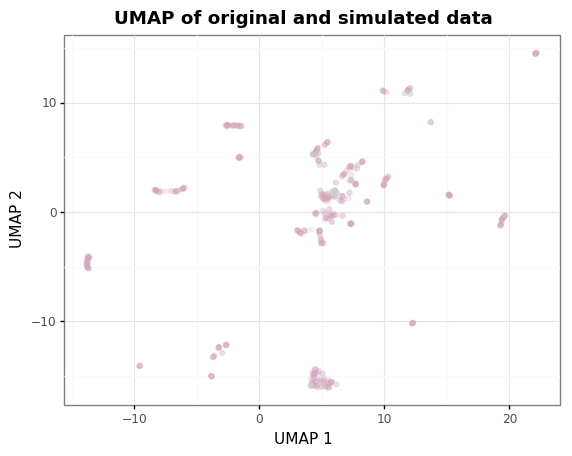

<ggplot: (-9223363259863405610)>


In [24]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

#combined_data_df[combined_data_df['dataset'] == 'original']
# Plot
g_input_sim = ggplot(combined_data_df[combined_data_df['dataset'] == 'original'], aes(x='1', y='2'))
#g_input_sim += geom_point(aes(color='dataset'),
#                         alpha=0.2)
g_input_sim += geom_point(color='#d5a6bd',
                          alpha=0.1)
g_input_sim += labs(x = "UMAP 1", 
                    y = "UMAP 2", 
                    title = "UMAP of original and simulated data")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
)
#g_input_sim += guides(colour=guide_legend(override_aes={'alpha': 1}))
#g_input_sim += scale_color_manual(['#d5a6bd', '#cccccc'])
g_input_sim += geom_point(combined_data_df[combined_data_df['dataset'] == 'simulated'],
                          alpha=0.5, 
                          color='#cccccc')

print(g_input_sim)
ggsave(plot = g_input_sim, filename = umap_overlay_file, dpi=500)